## Examine and understand the data

In [1]:
# import important libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
import os
import tensorflow as tf

## Build an input pipeline

In [2]:
# data download
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin = url, extract = True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [3]:
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'validation')

batch_size = 32
image_size = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle = True,
                                                            batch_size = batch_size,
                                                            image_size = image_size)
validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle = True,
                                                            batch_size = batch_size,
                                                            image_size = image_size)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


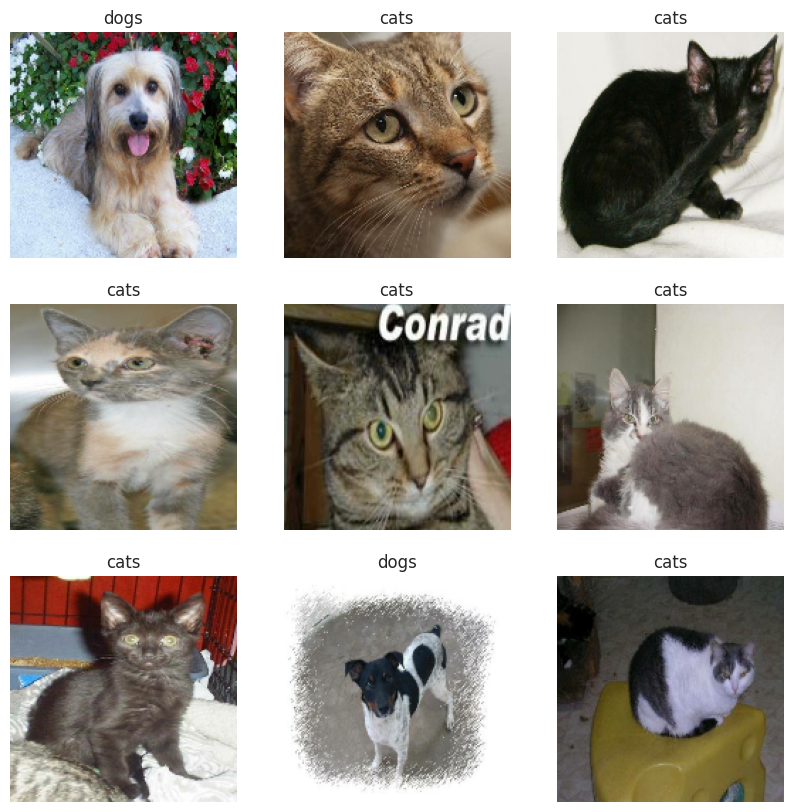

In [4]:
# show the first 9 images and labels from training data
class_names = train_dataset.class_names

plt.figure(figsize = (10, 10))
for img, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [5]:
# move 20% of the validation data to test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('number of validation batches: %d' % val_batches)
print('number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

number of validation batches: 32
number of test batches: 6


In [6]:
# Use buffered prefetching to load images from disk without having I/O become blocking.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(AUTOTUNE)
test_dataset = test_dataset.prefetch(AUTOTUNE)
validation_dataset = validation_dataset.prefetch(AUTOTUNE)

### Data Augmentaion

In [7]:
data_augmentaion = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomBrightness(factor = 0.2)
])

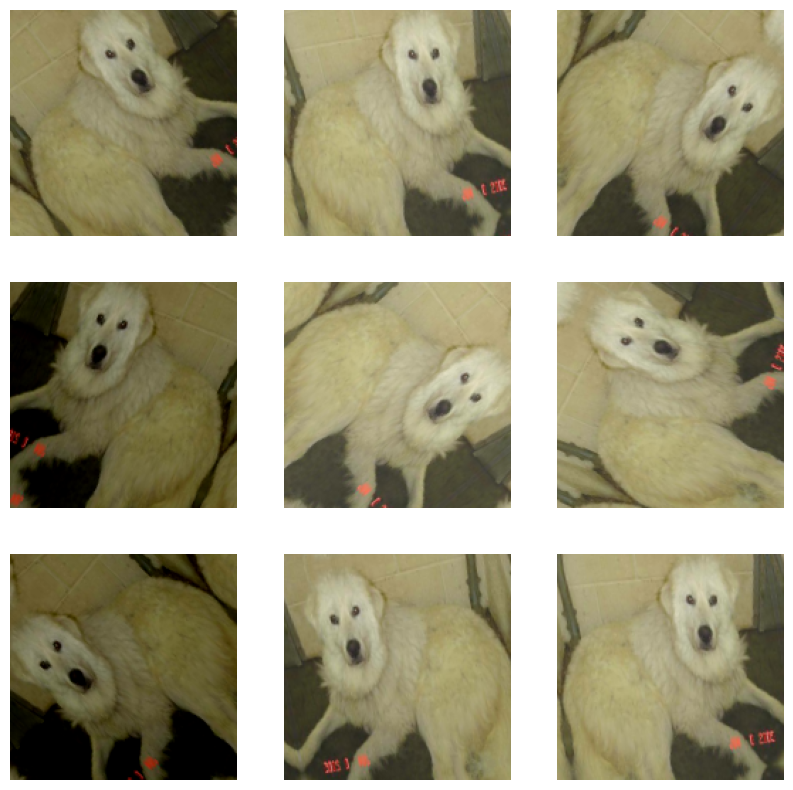

In [8]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentaion(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Compose the model
- load in the pretrained base model
- stack the classification layers on top

#### we will use MobileNetV2pretrained model , This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset = -1)

#### We will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset

In [10]:
# feature extractor
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape = image_size + (3,),
                                                    include_top = False,
                                                    weights = 'imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = mobilenet_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [11]:
mobilenet_model.trainable = False

In [12]:
mobilenet_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [13]:
# To generate predictions from the block of features, average over the spatial 5x5 spatial locations,
# using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 1280])

In [14]:
output_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')
prediction_batch = output_layer(feature_batch_average)
prediction_batch.shape

TensorShape([32, 1])

## Build the model

In [15]:
inputs = tf.keras.Input(shape = (160, 160, 3))
x = data_augmentaion(inputs)
x = preprocess_input(x)
x = mobilenet_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

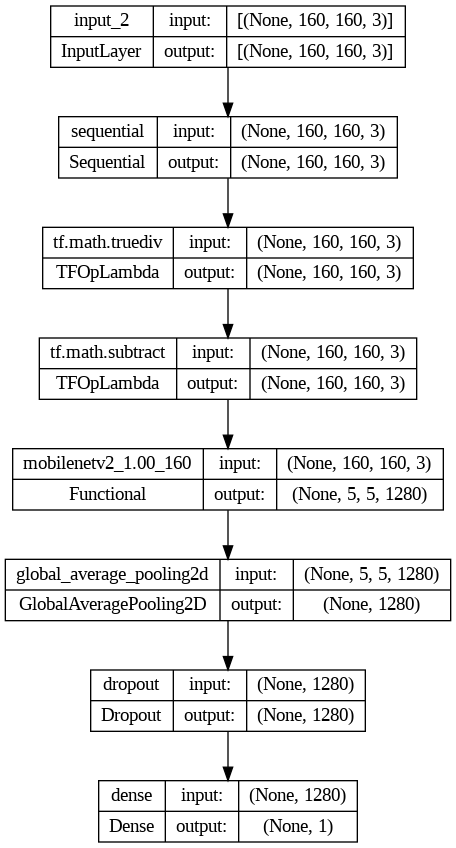

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
tf.random.set_seed(42)
# compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])
# fit the model
history = model.fit(train_dataset, epochs = 10, steps_per_epoch = len(train_dataset),
          validation_data = validation_dataset,
          validation_steps = len(validation_dataset))

Epoch 1/10
63/63 [==============================] - 9s 97ms/step - loss: 0.3836 - accuracy: 0.8170 - val_loss: 0.1312 - val_accuracy: 0.9579
Epoch 2/10
63/63 [==============================] - 3s 50ms/step - loss: 0.1944 - accuracy: 0.9235 - val_loss: 0.0776 - val_accuracy: 0.9802
Epoch 3/10
63/63 [==============================] - 3s 52ms/step - loss: 0.1556 - accuracy: 0.9370 - val_loss: 0.0662 - val_accuracy: 0.9827
Epoch 4/10
63/63 [==============================] - 4s 66ms/step - loss: 0.1417 - accuracy: 0.9445 - val_loss: 0.0611 - val_accuracy: 0.9827
Epoch 5/10
63/63 [==============================] - 3s 52ms/step - loss: 0.1459 - accuracy: 0.9400 - val_loss: 0.0611 - val_accuracy: 0.9827
Epoch 6/10
63/63 [==============================] - 4s 52ms/step - loss: 0.1392 - accuracy: 0.9475 - val_loss: 0.0520 - val_accuracy: 0.9876
Epoch 7/10
63/63 [==============================] - 4s 68ms/step - loss: 0.1252 - accuracy: 0.9475 - val_loss: 0.0530 - val_accuracy: 0.9851
Epoch 8/10
63

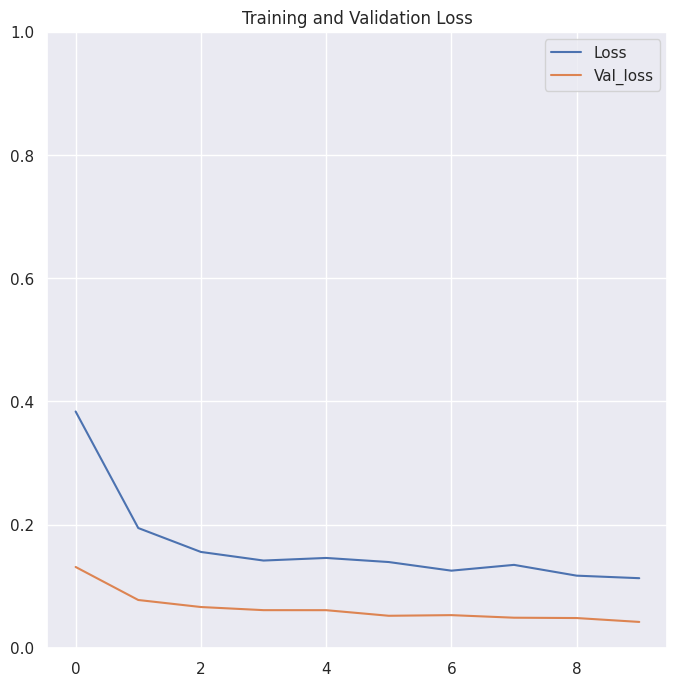

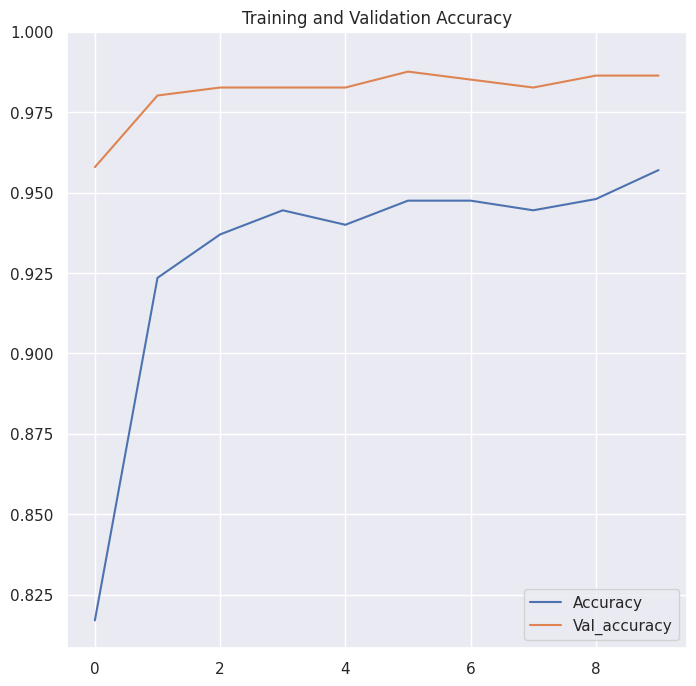

In [24]:
# Learning Curves
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.title('Training and Validation Loss')
plt.plot(epochs, loss, label = 'Loss')
plt.plot(epochs, val_loss, label = 'Val_loss')
plt.legend()
plt.ylim([0,1.0])
plt.show()

plt.figure(figsize=(8, 8))
plt.title('Training and Validation Accuracy')
plt.plot(epochs, acc, label = 'Accuracy')
plt.plot(epochs, val_acc, label = 'Val_accuracy')
plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.show()

## Fine Tuning

In [26]:
# Un-freeze the top layers of the model
mobilenet_model.trainable = False

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenet_model.layers))

Number of layers in the base model:  154


In [27]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet_model.layers[:100]:   # fine tune from layer(100)
  layer.trainable = False

In [28]:
tf.random.set_seed(42)
# compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])
# fit the model
history = model.fit(train_dataset, epochs = 20, steps_per_epoch = len(train_dataset),
          validation_data = validation_dataset,
          validation_steps = len(validation_dataset))

Epoch 1/20
63/63 [==============================] - 7s 65ms/step - loss: 0.1099 - accuracy: 0.9575 - val_loss: 0.0463 - val_accuracy: 0.9864
Epoch 2/20
63/63 [==============================] - 5s 66ms/step - loss: 0.1137 - accuracy: 0.9580 - val_loss: 0.0413 - val_accuracy: 0.9851
Epoch 3/20
63/63 [==============================] - 4s 60ms/step - loss: 0.1111 - accuracy: 0.9500 - val_loss: 0.0459 - val_accuracy: 0.9839
Epoch 4/20
63/63 [==============================] - 4s 65ms/step - loss: 0.1042 - accuracy: 0.9545 - val_loss: 0.0397 - val_accuracy: 0.9864
Epoch 5/20
63/63 [==============================] - 4s 55ms/step - loss: 0.0982 - accuracy: 0.9625 - val_loss: 0.0393 - val_accuracy: 0.9876
Epoch 6/20
63/63 [==============================] - 4s 58ms/step - loss: 0.1027 - accuracy: 0.9595 - val_loss: 0.0414 - val_accuracy: 0.9864
Epoch 7/20
63/63 [==============================] - 5s 69ms/step - loss: 0.0941 - accuracy: 0.9615 - val_loss: 0.0404 - val_accuracy: 0.9851
Epoch 8/20
63

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

## Evaluate the model

In [31]:
loss, accuracy = model.evaluate(test_dataset)
print('Test Accuracy: ', accuracy)

6/6 [==============================] - 0s 37ms/step - loss: 0.0270 - accuracy: 0.9948
Test Accuracy:  0.9947916865348816


### Predictions

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0]


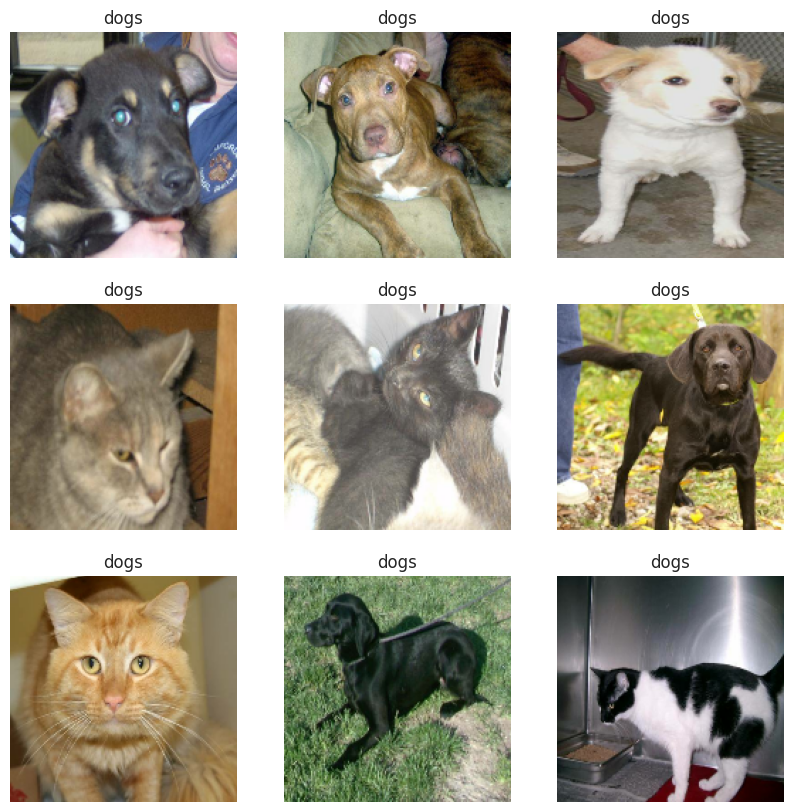

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")